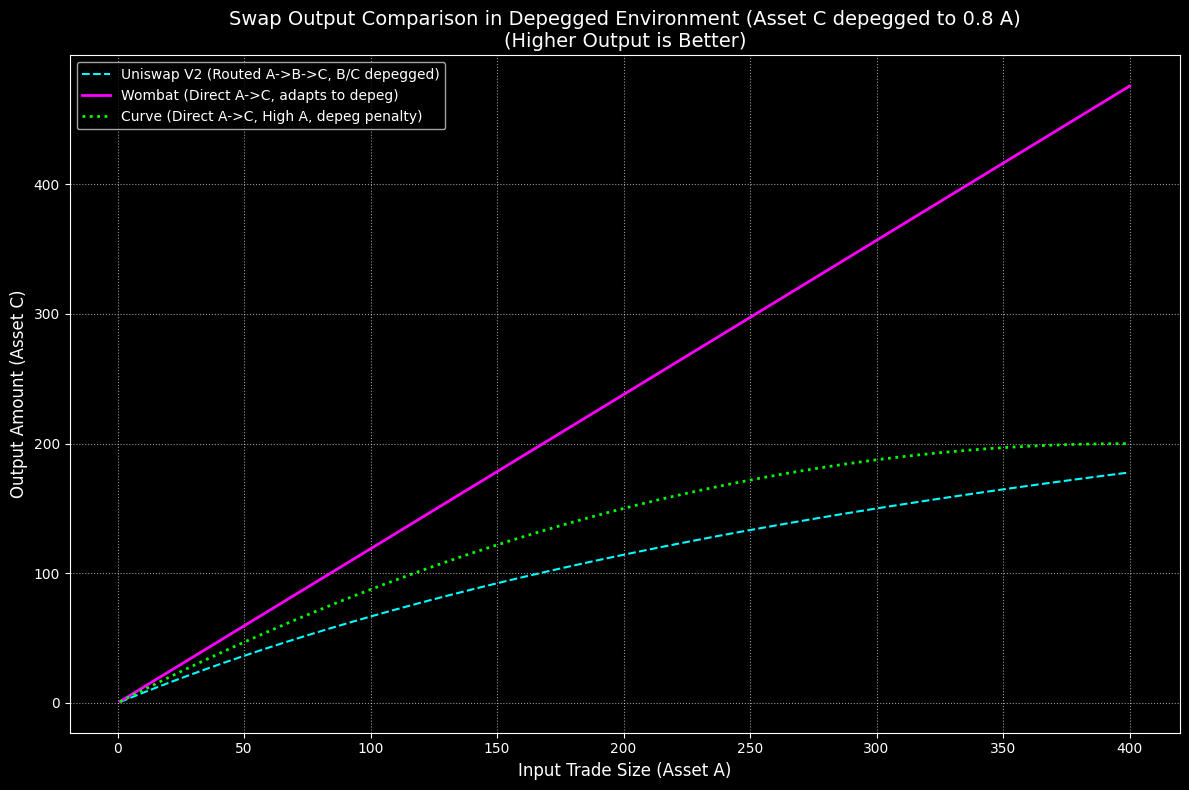

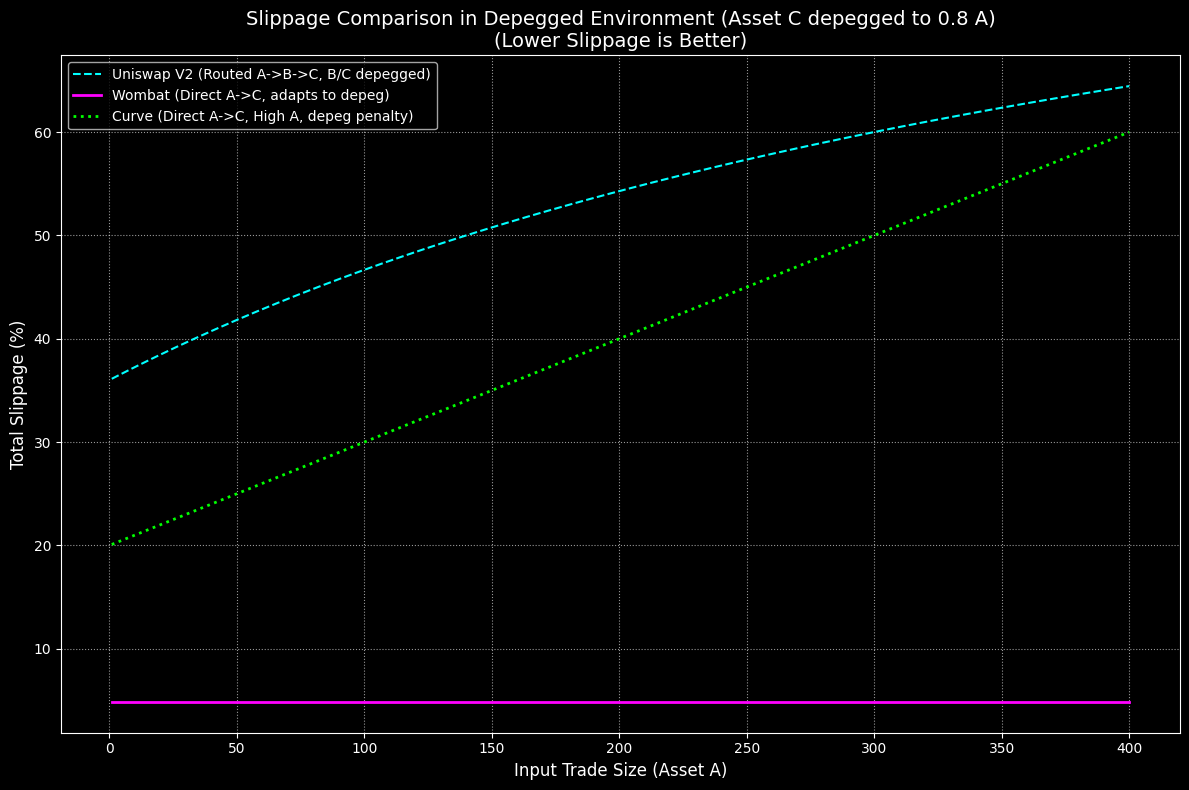

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Uniswap V2 Functions ---
def uniswap_v2_pool(reserve_a, reserve_b):
    """Creates a constant product pool."""
    if reserve_a <= 0 or reserve_b <= 0:
        return {'a': 0, 'b': 0, 'k': 0}
    return {'a': reserve_a, 'b': reserve_b, 'k': reserve_a * reserve_b}

def uniswap_v2_swap(pool, amount_in):
    """Calculates swap output. Returns 0 if pool is empty."""
    if pool['k'] <= 0 or (pool['a'] + amount_in) <= 0:
        return 0, pool
    
    initial_reserves_b = pool['b']
    amount_out = initial_reserves_b - pool['k'] / (pool['a'] + amount_in)
    
    final_pool_a = pool['a'] + amount_in
    final_pool_b = initial_reserves_b - amount_out
    
    return amount_out, uniswap_v2_pool(final_pool_a, final_pool_b)

# --- Wombat Functions ---
def wombat_style_pool(reserves, liabilities, prices, alpha):
    """Creates a simplified Wombat-style pool."""
    return {
        'assets': reserves.copy(),
        'liabilities': liabilities.copy(),
        'prices': prices,
        'alpha': alpha
    }

def wombat_swap(pool, amount_in, token_in, token_out):
    """
    Simulates a swap in a Wombat-style pool, emphasizing its handling of depegged assets.
    """
    r_in = pool['assets'][token_in] / pool['liabilities'][token_in]
    r_out = pool['assets'][token_out] / pool['liabilities'][token_out]
    
    base_price_in = pool['prices'][token_in]
    base_price_out = pool['prices'][token_out]
    
    numerator = base_price_in * (1 + pool['alpha'] / (r_in**2))
    denominator = base_price_out * (1 + pool['alpha'] / (r_out**2))
    
    effective_price = numerator / denominator
    
    amount_out = amount_in * effective_price
    
    if pool['assets'][token_out] - amount_out < 0:
        amount_out = pool['assets'][token_out] * 0.999
        
    pool['assets'][token_in] += amount_in
    pool['assets'][token_out] -= amount_out
    
    return amount_out, pool

# --- Curve Finance Functions ---
def curve_pool(reserves, A):
    """Creates a simplified Curve-style pool."""
    return {
        'reserves': reserves.copy(),
        'A': A
    }

def curve_swap(pool, amount_in, token_in, token_out, depeg_factor=1.0):
    """
    Simulates a swap in a simplified Curve-style pool in a volatile environment.
    """
    initial_reserve_in = pool['reserves'][token_in]
    initial_reserve_out = pool['reserves'][token_out]
    
    fair_output_before_amm_slippage = amount_in * (1 / depeg_factor)
    
    implied_pool_price_ratio = initial_reserve_out / initial_reserve_in 
    internal_deviation = abs(1.0 - implied_pool_price_ratio)
    market_deviation = abs(1.0 - depeg_factor)
    
    depeg_slippage_penalty = (market_deviation + internal_deviation) * pool['A'] * 0.0005
    trade_size_slippage = amount_in / initial_reserve_in
    
    total_slippage_factor = trade_size_slippage + depeg_slippage_penalty
    total_slippage_factor = min(total_slippage_factor, 0.99)
    
    amount_out = fair_output_before_amm_slippage * (1 - total_slippage_factor)
    
    if pool['reserves'][token_out] - amount_out < 0:
        amount_out = pool['reserves'][token_out] * 0.999
        
    pool['reserves'][token_in] += amount_in
    pool['reserves'][token_out] -= amount_out
    
    return amount_out, pool

# --- Main Comparative Simulation (Swap Output & Slippage) ---

def run_comparative_simulation_volatile():
    """
    Runs a simulation comparing Uniswap V2, Wombat, and Curve swaps
    in a highly volatile environment where one asset (C) is depegged.
    Generates two separate plots for swap output and slippage.
    """
    trade_sizes = np.linspace(1, 400, 50)
    
    uniswap_outputs = []
    wombat_outputs = []
    curve_outputs = []
    
    uniswap_slippages = []
    wombat_slippages = []
    curve_slippages = []

    depeg_market_price_ratio_A_to_C = 0.8
    ideal_output_per_unit_A = 1 / depeg_market_price_ratio_A_to_C

    initial_pool_ab = uniswap_v2_pool(1000, 1000)
    initial_pool_bc_depegged = uniswap_v2_pool(1000, 800)

    initial_wombat_pool_reserves = {'a': 1000, 'b': 1000, 'c': 800}
    initial_wombat_pool_liabilities = {'a': 1000, 'b': 1000, 'c': 1000}
    initial_wombat_pool_prices = {'a': 1.0, 'b': 1.0, 'c': depeg_market_price_ratio_A_to_C} 
    initial_wombat_pool = wombat_style_pool(
        initial_wombat_pool_reserves,
        initial_wombat_pool_liabilities,
        initial_wombat_pool_prices,
        alpha=0.1
    )
    
    initial_curve_pool_reserves = {'a': 1000, 'c': 1000}
    initial_curve_pool = curve_pool(initial_curve_pool_reserves, A=2000)

    for size in trade_sizes:
        # Uniswap V2 Routed Swap
        pool_ab = initial_pool_ab.copy()
        pool_bc = initial_pool_bc_depegged.copy()
        
        amount_b_out, _ = uniswap_v2_swap(pool_ab, size)
        final_c_out_uni, _ = uniswap_v2_swap(pool_bc, amount_b_out)
        
        uniswap_outputs.append(final_c_out_uni)
        
        if size > 0:
            ideal_output_for_this_trade = size * ideal_output_per_unit_A
            slippage_uni = ((ideal_output_for_this_trade - final_c_out_uni) / ideal_output_for_this_trade) * 100
            uniswap_slippages.append(max(0, slippage_uni))
        else:
            uniswap_slippages.append(0)

        # Wombat Unified Swap
        wombat_pool = wombat_style_pool(
            initial_wombat_pool_reserves.copy(),
            initial_wombat_pool_liabilities.copy(),
            initial_wombat_pool_prices.copy(),
            alpha=initial_wombat_pool['alpha']
        )
        final_c_out_wombat, _ = wombat_swap(wombat_pool, size, 'a', 'c')
        wombat_outputs.append(final_c_out_wombat)
        
        if size > 0:
            ideal_output_for_this_trade = size * ideal_output_per_unit_A
            slippage_wombat = ((ideal_output_for_this_trade - final_c_out_wombat) / ideal_output_for_this_trade) * 100
            wombat_slippages.append(max(0, slippage_wombat))
        else:
            wombat_slippages.append(0)
            
        # Curve Unified Swap
        curve_pool_current = curve_pool(initial_curve_pool_reserves.copy(), A=initial_curve_pool['A'])
        final_c_out_curve, _ = curve_swap(curve_pool_current, size, 'a', 'c', depeg_factor=depeg_market_price_ratio_A_to_C)
        curve_outputs.append(final_c_out_curve)

        if size > 0:
            ideal_output_for_this_trade = size * ideal_output_per_unit_A
            slippage_curve = ((ideal_output_for_this_trade - final_c_out_curve) / ideal_output_for_this_trade) * 100
            curve_slippages.append(max(0, slippage_curve))
        else:
            curve_slippages.append(0)

    plt.style.use('dark_background')

    # Plot 1: Final Output vs. Trade Size
    plt.figure(figsize=(12, 8))
    plt.plot(trade_sizes, uniswap_outputs, label='Uniswap V2 (Routed A->B->C, B/C depegged)', color='cyan', linestyle='--')
    plt.plot(trade_sizes, wombat_outputs, label='Wombat (Direct A->C, adapts to depeg)', color='magenta', linewidth=2)
    plt.plot(trade_sizes, curve_outputs, label='Curve (Direct A->C, High A, depeg penalty)', color='lime', linewidth=2, linestyle=':')
    plt.title(f'Swap Output Comparison in Depegged Environment (Asset C depegged to {depeg_market_price_ratio_A_to_C} A)\n(Higher Output is Better)', fontsize=14)
    plt.xlabel('Input Trade Size (Asset A)', fontsize=12)
    plt.ylabel('Output Amount (Asset C)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig("swap_output_depegged_environment.png")
    plt.show()

    # Plot 2: Slippage vs. Trade Size
    plt.figure(figsize=(12, 8))
    plt.plot(trade_sizes, uniswap_slippages, label='Uniswap V2 (Routed A->B->C, B/C depegged)', color='cyan', linestyle='--')
    plt.plot(trade_sizes, wombat_slippages, label='Wombat (Direct A->C, adapts to depeg)', color='magenta', linewidth=2)
    plt.plot(trade_sizes, curve_slippages, label='Curve (Direct A->C, High A, depeg penalty)', color='lime', linewidth=2, linestyle=':')
    plt.title(f'Slippage Comparison in Depegged Environment (Asset C depegged to {depeg_market_price_ratio_A_to_C} A)\n(Lower Slippage is Better)', fontsize=14)
    plt.xlabel('Input Trade Size (Asset A)', fontsize=12)
    plt.ylabel('Total Slippage (%)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig("slippage_depegged_environment.png")
    plt.show()

# --- NEW: Impermanent Loss Simulation ---

def calculate_uniswap_v2_il_percentage(price_ratio):
    """Calculates theoretical IL for a 50/50 Uniswap V2 pool in percentage."""
    if price_ratio <= 0:
        return np.inf # Or handle as an error / extreme case

    # IL formula for a 50/50 pool: abs(2 * sqrt(price_ratio) / (1 + price_ratio) - 1)
    # We take absolute value as IL is generally reported as a positive loss.
    il_decimal = (2 * np.sqrt(price_ratio) / (1 + price_ratio)) - 1
    return abs(il_decimal) * 100

def run_impermanent_loss_simulation():
    """
    Simulates and plots Impermanent Loss for Uniswap V2 and conceptually for Wombat.
    """
    # Range of price ratios (final price / initial price)
    # 0.1 means price dropped to 10% of original; 3.0 means price tripled.
    price_ratios = np.linspace(0.1, 3.0, 100) 

    uniswap_ils = []
    wombat_conceptual_ils = []

    # Conceptual mitigation factors for Wombat's IL.
    # These are illustrative values representing Wombat's design goals.
    # Dynamic fees and re-pegging are designed to offset a portion of the base IL.
    # This is a simplification to illustrate the intended effect.
    total_wombat_mitigation_factor = 0.40 # Hypothetically, Wombat's mechanisms reduce base IL by 40%

    for pr in price_ratios:
        # Uniswap V2 IL: This is the baseline impermanent loss.
        uni_il = calculate_uniswap_v2_il_percentage(pr)
        uniswap_ils.append(uni_il)

        # Wombat Conceptual IL: Base IL reduced by mitigation factor.
        # Wombat's design aims to provide LPs with lower net IL due to:
        # 1. Dynamic fees offsetting losses.
        # 2. Re-pegging mechanism actively reducing price divergence effects.
        wombat_il = uni_il * (1 - total_wombat_mitigation_factor)
        wombat_conceptual_ils.append(max(0, wombat_il)) # Ensure IL doesn't go below 0

    # Plotting Impermanent Loss
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 8))
    
    plt.plot(price_ratios, uniswap_ils, label='Uniswap V2 (Standard 50/50 Pool)', color='cyan', linestyle='--')
    plt.plot(price_ratios, wombat_conceptual_ils, label=f'Wombat (Conceptual Net IL with {total_wombat_mitigation_factor*100:.0f}% Mitigation)', color='magenta', linewidth=2)

    plt.title('Impermanent Loss Comparison (Lower IL is Better)', fontsize=14)
    plt.xlabel('Price Ratio (Final Price / Initial Price)', fontsize=12)
    plt.ylabel('Impermanent Loss (%)', fontsize=12)
    plt.xticks(np.arange(0.1, 3.1, 0.2))
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig("impermanent_loss_comparison.png")
    plt.show()

# --- Run All Simulations ---
run_comparative_simulation_volatile()
run_impermanent_loss_simulation()